<a href="https://colab.research.google.com/github/IHMilon/Model-Compression-and-NAS/blob/main/Model%20Pruning/notebook%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-Grained Magnitude Based Pruning on VGG Network**

In this project, I apply **fine-grained magnitude based pruning** on a **VGG model** to reduce its parameters while maintaining performance.  
The goal is to explore how pruning affects model sparsity, weight distribution, and accuracy and then fine-tune the pruned model to regain lost performance.

## **Install and Import Required libraries**

In [1]:
! pip install torchprofile 1>/dev/null

In [2]:
import math
import time
import copy
import random
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision import transforms
from tqdm.auto import tqdm

from torchprofile import profile_macs
from collections import OrderedDict,defaultdict

## **Device Setup**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is:', device)

Device is: cuda


## **Define the Model, Training & Evaluation Functions**

Here we need to create the **exact same model architecture** as we pretrained in the **VGG on CIFAR10** project.

We will also define:

-  **Training function** for fine-tuning  
-  **Evaluation function** to calculate model accuracy  
- **Helper functions** to compute model information such as:  
  - Number of parameters (`#Params`)  
  - Multiply Accumulate operations (`#MACs`)  
  - Model size  
  - Sparsity level

In [4]:
# Architecture exactly same as pretrained one
class VGGM(nn.Module):
  # model config
  ARCH = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M']

  def __init__(self):
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name, layer):
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier1 = nn.Sequential(
              nn.Linear(512, 128),
              nn.BatchNorm1d(128),
              nn.ReLU(),
              nn.Dropout(0.5)
              )
    self.classifier2 = nn.Linear(128, 10)

  def forward(self, x):
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 128] => [N, 10]
    x = self.classifier1(x)
    x = self.classifier2(x)
    return x

model = VGGM().to(device)

In [5]:
# Training function for fine-tuning
def train(model, dataloader, criterion, optimizer, scheduler, callbacks = None):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels) # Corrected order for CrossEntropyLoss
        optimizer.zero_grad() # Added to clear gradients
        loss.backward() #Gradient calculation
        optimizer.step() #parameters update

        if callbacks is not None: # To reapply mask during fine-tuning
            for callback in callbacks:
                callback()

        # Update the lr
        scheduler.step()

In [6]:
# Evaluation Function for accuracy
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    samples = 0
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            class_pred = outputs.argmax(dim = 1)
            correct += (class_pred == labels).sum()
            samples += labels.size(0)
    # Returns accuracy
    return ((correct/samples)*100).item()

In [7]:
# Counts number of parameters
def num_params(model, non_zeros = False):
    total_param = 0
    for params in model.parameters():
        if non_zeros: # Counts non zeros only
            total_param += params.count_nonzero()
        else: # Counts all parameters
            total_param += params.numel()
    return total_param

# Calculates the model size in MiB
def model_size(model, non_zeros = False):
    # size calculator
    byte = 8
    kib = byte*1024
    mib = kib*1024
    total_params = num_params(model, non_zeros)
    return (total_params * 32) /mib

# Calculate the sparsity of tensor
def sparsity(tensor):
    num_params = tensor.count_nonzero()
    total = tensor.numel()
    # Sparsity = #zeros / #params = 1 - (#nonzeros / #params)
    sparsity_val = 1 - (num_params/total)
    return sparsity_val

## **Download the dataset and prepare it**

In [8]:
# Train transformation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])
# test one is only converted to tensor
test_transform = transforms.ToTensor()

In [9]:
# Getting training samples
train_data = torchvision.datasets.CIFAR10(root = "./data", train = True, transform = train_transforms, download = True)
train_loader = DataLoader(train_data, shuffle = True, batch_size = 128, pin_memory = True)

# Getting validation samples
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = test_transform)
test_loader = DataLoader(test_data, batch_size = 128, pin_memory = True)

100%|██████████| 170M/170M [00:14<00:00, 12.2MB/s]


## **Load the pretrained weights to the defined model**

In [10]:
# Loading the pretrained weights to the model
model.load_state_dict(torch.load('/content/model_weights.pth'))
# backup the model to recover when needed
recover_model = lambda: model.load_state_dict(torch.load('/content/model_weights.pth'))

## **Calculate the accuracy and size of the model**

In [11]:
# Accuracy and Size of the Original model
original_acc = evaluate(model, test_loader)
original_size = model_size(model)
print(f'Original accuracy: {original_acc:.1f}%')
print(f'Original size: {original_size:.2f} MiB')

Original accuracy: 92.2%
Original size: 18.14 MiB


The model has 92% accuracy and takes 18 MiB storage.

## **Visualize Weight Distribution**  
Here we can visualize each layer's weights distribution to understand their overall pattern before **Pruning**.  

We all know that neural network weights are generally **normally distributed**.

In [48]:
# Plots the Distribution of each layer's weights
def plot_weight_distribution(model, non_zeros = False, bins = 256):
    figs, axis = plt.subplots(5, 2, figsize = (8, 7))
    axis = axis.ravel() # makes the plot index 1d
    plot_idx = 0
    for name, params in model.named_parameters():
        if params.dim() > 1: #plot only the weights not bias.
            ax = axis[plot_idx]
            if non_zeros: # plot the nonzeros elements only
                param = params.detach().view(-1).cpu()#detach from computation graph and makes 1d
                param = param[param != 0].view(-1) #keeps non zeros only
                ax.hist(param, bins = bins, color = 'blue', density = True) #Plot histogram
            else:#plot all weights
                param = params.detach().view(-1).cpu()
                ax.hist(param, bins = bins, color = 'blue', density = True)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_idx += 1
    figs.suptitle('Weights Distribution')
    figs.tight_layout()
    figs.subplots_adjust(top = 0.9)
    plt.show()

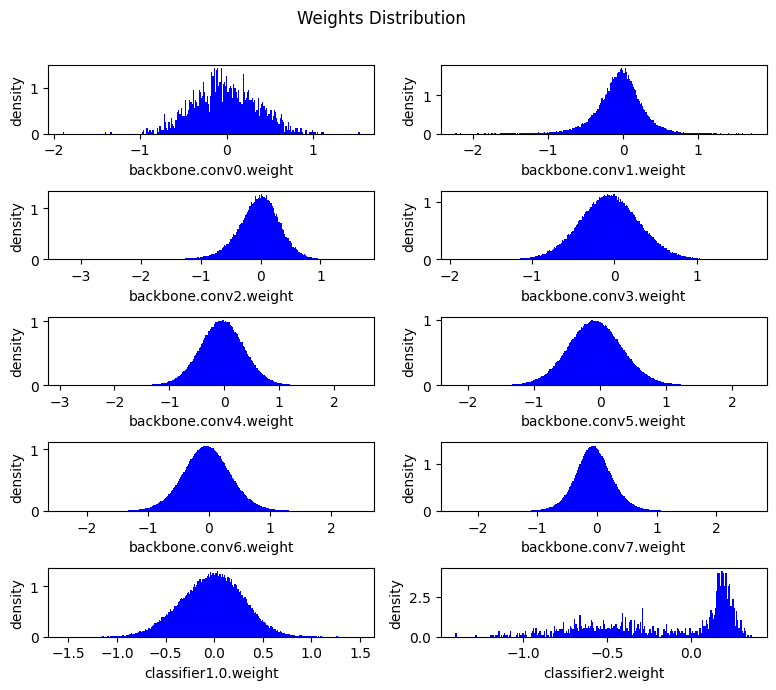

In [14]:
# Plot all layers weight distribution
plot_weight_distribution(model)

We can observe that most of the weights are concentrated around zero, indicating that many parameters contribute very little to the model’s output. These near zero weights are ideal candidates for pruning, allowing us to reduce model complexity without significantly affecting performance.

## **Function to Prune the Model**
Here, I will implement the fine-grained pruning.
Fine-grained pruning removes the synapses with lowest importance. So, The weight tensor  W  will become sparse after fine-grained pruning.

We first need to get the number of zeros for a specific sparsity. Then we calculate the importance and determine the threshold till which we will prune the weights. After that, we create the pruning mask and prune the model.

In [15]:
# Function to Prune tensor
@torch.no_grad()
def prune_tensor(tensor, sparsity):
    # ensure the sparsity is between 0.0 to 1.0
    sparsity = min(max(0.0, sparsity), 1.0)
    # surpasses calculation for 0.0 and 1.0 sparsity
    if sparsity == 0.0:
        return tensor
    if sparsity ==1.0:
        return torch.zeros_like(tensor)

    #calculate the expected zeros for that sparsity
    total_param = tensor.numel()
    num_zeros = round(total_param * sparsity)

    # Calculate the importance of each tensor by and
    importance = torch.abs(tensor)

    # Determine the threshold value
    threshold = torch.kthvalue(importance.view(-1), num_zeros).values
    # Create the mask 0 = prune and 1 == keep
    mask = torch.gt(importance, threshold)

    # Apply mask to the tensor
    tensor.mul_(mask)
    #return the mask matrix for reapply mask during fine-tuning
    return mask

In [16]:
# To prune the full model
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        # Store masks for each layers
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    # Used to reapply the masks during fine-tuning
    @torch.no_grad()
    def apply(self, model):
        for name, params in model.named_parameters():
            if name in self.masks:
                # Applies the masks to the layer
                params *= self.masks[name]

    # For pruning the full model
    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict() #store masks of each layers
        for name, params in model.named_parameters():
            if params.dim() > 1: #apply except bias
                masks[name] = prune_tensor(params, sparsity_dict[name])
        return masks

## **Sensitivity Scan**

To know how sensitive each layer is with the increase of pruning ratios, we need to analyze the sensitivity of each layer for different ratios.

It helps us to pick right pruning ratios for each layer without losing much accuracy.

It has only one limitation that it ignores the relationship among layers.

In [17]:
@torch.no_grad()
def sensitivity(model, dataloader, start = 0.3, stop = 0.9, step = 0.1, verbose = True):
    # Create the sparsities
    sparsities = np.arange(start = start, stop = stop, step = step)
    accuracies = list()
    # loop over all layers of the model
    for name, params in model.named_parameters():
        # Colone params to keep original params intact
        param_clone = params.detach().clone()
        if params.dim() > 1: # apply only to the weights not biases
            # applies all sparsities to a single layer and store accuracy
            accuracy = list()
            for sparsity in tqdm(sparsities, desc = f'Scaning: {name}'):
                prune_tensor(params.detach(), sparsity)
                acc = evaluate(model, dataloader)
                # regain the original weights
                params.copy_(param_clone)
                accuracy.append(acc)
            if verbose:
                print(f'Sparsities =[{','.join(["{:.2f}".format(x) for x in sparsities])}]| \nAccuracy = [{','.join(["{:.2f}%".format(x) for x in accuracy])}]')
            accuracies.append(accuracy)
    return sparsities, accuracies

In [18]:
# Scan each layer with different sparsities and track accuracy
sparsities, accuracies = sensitivity(model, test_loader)

Scaning: backbone.conv0.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [90.91%,89.46%,87.56%,75.42%,63.80%,62.95%,18.95%]


Scaning: backbone.conv1.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.06%,91.95%,92.14%,91.87%,91.45%,90.45%,84.99%]


Scaning: backbone.conv2.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.19%,91.99%,91.45%,90.58%,87.79%,79.83%,55.03%]


Scaning: backbone.conv3.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.05%,92.15%,92.02%,91.57%,90.52%,85.75%,68.32%]


Scaning: backbone.conv4.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.21%,92.06%,92.01%,91.99%,91.29%,88.93%,67.68%]


Scaning: backbone.conv5.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.08%,92.10%,92.19%,92.00%,91.43%,90.11%,79.44%]


Scaning: backbone.conv6.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.23%,92.14%,92.20%,92.08%,91.99%,91.50%,88.60%]


Scaning: backbone.conv7.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.17%,92.14%,92.11%,92.09%,92.02%,91.96%,91.46%]


Scaning: classifier1.0.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [92.13%,92.08%,92.03%,92.00%,91.85%,91.60%,90.71%]


Scaning: classifier2.weight:   0%|          | 0/7 [00:00<?, ?it/s]

Sparsities =[0.30,0.40,0.50,0.60,0.70,0.80,0.90]| 
Accuracy = [91.95%,91.88%,91.90%,91.88%,90.66%,89.21%,71.36%]


### **Plot the Sensitivity Scan for Visualization**

In [19]:
def plot_sensitivity(sparsities, accuracies, original_accuracy):
    # lowest acceptable accuracy after pruning
    lower_bound_accuracy = 100 - ((100 - original_accuracy)*1.5)
    figs, axis = plt.subplots(5, 2, figsize = (15, 12))
    # to make axis index 1d
    axis = axis.ravel()
    plot_idx = 0
    for name, params in model.named_parameters():
        if params.dim() > 1:
            ax = axis[plot_idx]
            # Plot the accuracy for different sparsity in single layer
            ax.plot(sparsities, accuracies[plot_idx])
            # Plot the minimum accuracy we want after pruning
            ax.plot(sparsities, [lower_bound_accuracy]*len(sparsities))
            ax.set_xticks(np.arange(start = 0.3, stop = 1.0, step = 0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend(['accuracy after pruning', f'{lower_bound_accuracy / original_acc * 100:.0f}% of Original accuracy'])
            ax.grid(axis = "x")
            plot_idx += 1
    figs.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    figs.tight_layout()
    figs.subplots_adjust(top=0.925)
    plt.show()

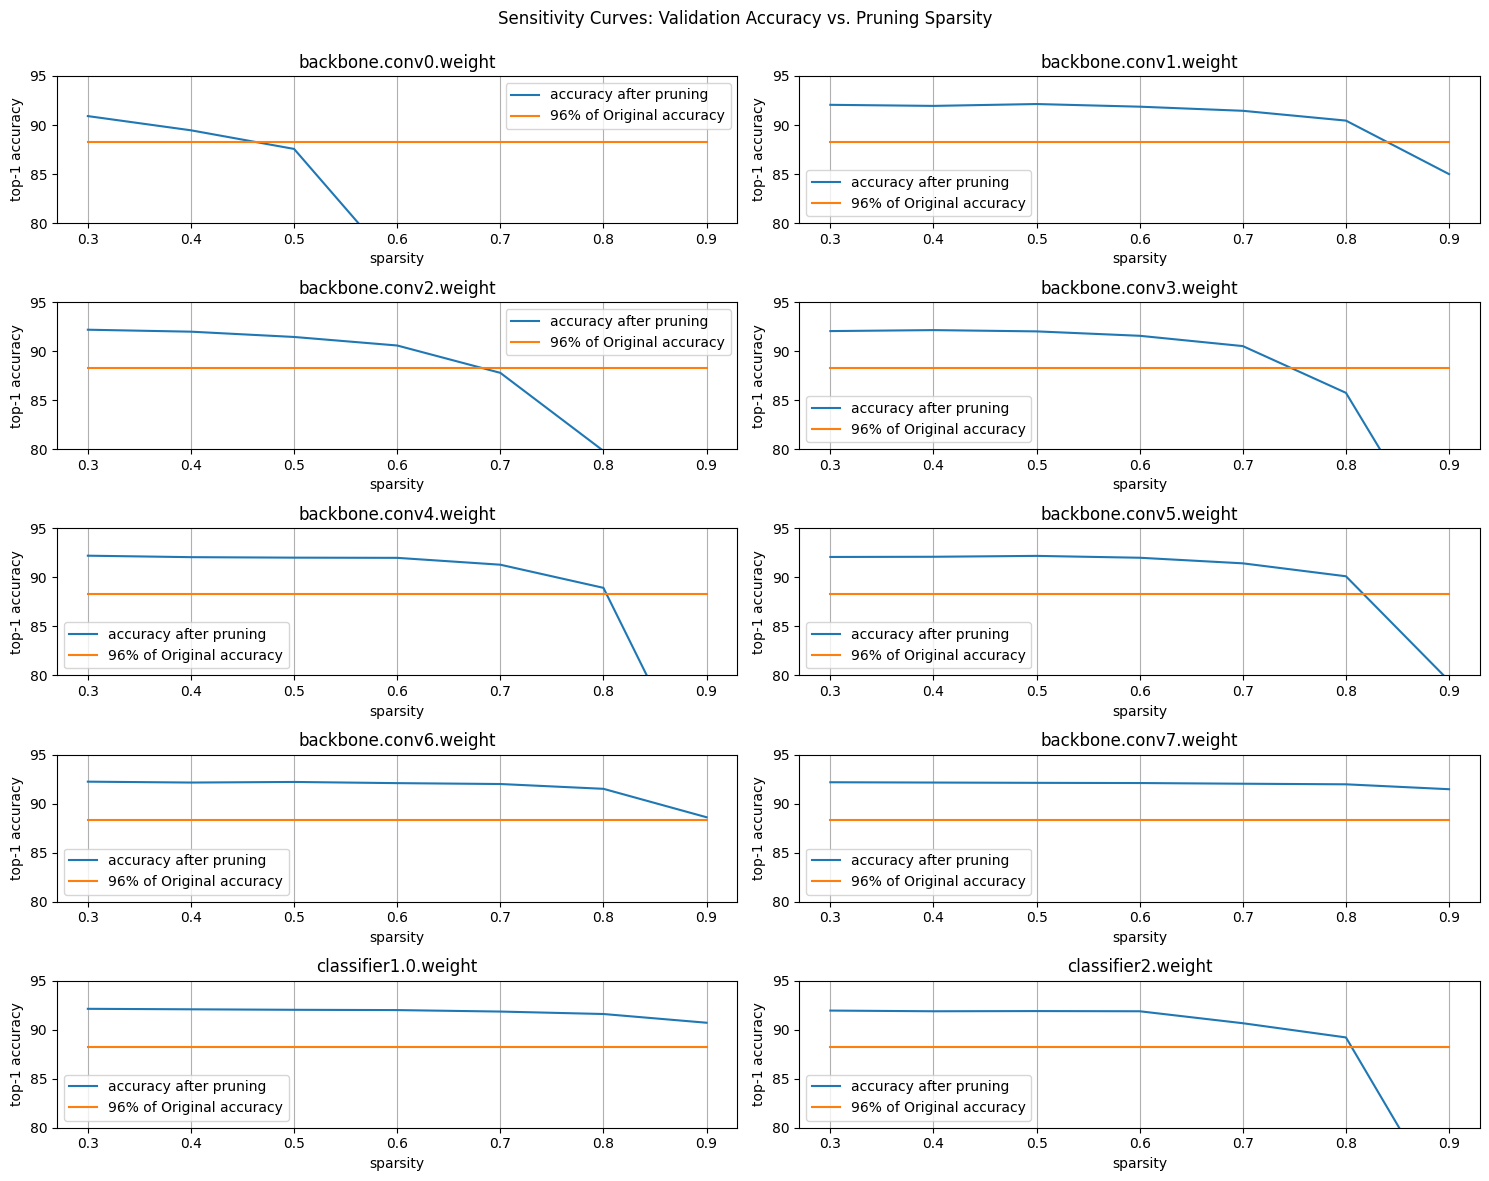

In [20]:
# Plot the scanings
plot_sensitivity(sparsities, accuracies, original_acc)

We can see that the **first layer** is highly sensitive, as expected, because it extracts low-level features such as edges. Additionally, **layers 4 and 5** also show notable sensitivity.

## **Visualization of #Parameters in Each Layer**
It helps us to choose the sparsity more precisely and accurately without losing much accuracy.

In [55]:
# Plots each layers weights
def plot_num_params(model, nonzeros = False):
    num_params = dict()
    for name, params in model.named_parameters():
        if params.dim() > 1:
            if nonzeros: #count nonzeros only
                num_params[name] = params.count_nonzero().cpu().item()
            else:
                num_params[name] = params.numel().cpu().item()
    plt.figure(figsize=(10,8))
    plt.grid(axis = 'y')
    # Bar plot for each layer
    plt.bar(list(num_params.keys()), list(num_params.values()))
    plt.yscale('log') # logarithmic scale
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

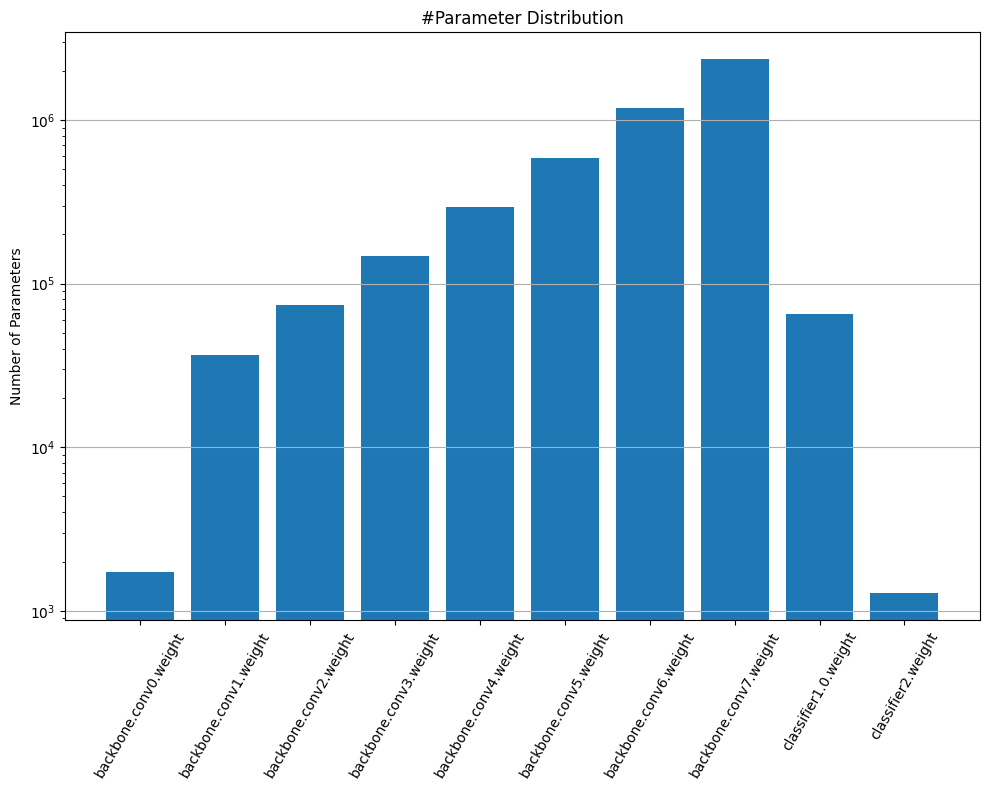

In [22]:
# Plot the info
plot_num_params(model)

By observing #parameters of each layer we can see that layer 5, 6, 7 has many parameters compared to others. So we can prune much weights here compared to others layers.

## **Select the Sparsities for Each Layer**
We need to analyze the sensitivity of each layer to different pruning ratios and also consider the number of parameters in each layer when setting the final pruning ratios.

In [41]:
#Recover the original unpruned model
recover_model()

# Set the sparsities dictionary
sparsities = {
    'backbone.conv0.weight': 0.3,
    'backbone.conv1.weight': 0.6,
    'backbone.conv2.weight': 0.5,
    'backbone.conv3.weight': 0.7,
    'backbone.conv4.weight': 0.7,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier1.0.weight': 0.9,
    'classifier2.weight':0.4
}

## **Prune the Model**
Now we’ll apply the pruning masks to remove less important weights from the model according to the sparsity settings.

In [42]:
# Prune the model
prune = FineGrainedPruner(model, sparsities)

# Print the Sparsities of each layer used for pruning
print('Pruning ratios used during pruning: ')
for name, pruning_ratio in sparsities.items(): # Renamed loop variable to avoid conflict
    print(f'{name}: {pruning_ratio}')

# Print the actual model sparsity of each layer
print('\nsparsity of each layer of the model: ')
for name, params in model.named_parameters():
    if name in sparsities:
        print(f'{name}: {sparsity(params):.2f}') # Now calls the function correctly

# Calculate the size of the pruned model
size = model_size(model, non_zeros = True)
print(f'\nPruned Model size is: {size:.2f} MiB ({int((size/original_size)*100)}% of Original model) | Original size: {original_size:.2f} MiB' )

# Get the accuracy of the pruned model before fine tuning
pruned_acc = evaluate(model, test_loader)
print(f'Pruned model accuracy: {pruned_acc:.1f}% (before fine-tuning)| Original accuracy: {original_acc:.1f}')

Pruning ratios used during pruning: 
backbone.conv0.weight: 0.3
backbone.conv1.weight: 0.6
backbone.conv2.weight: 0.5
backbone.conv3.weight: 0.7
backbone.conv4.weight: 0.7
backbone.conv5.weight: 0.8
backbone.conv6.weight: 0.8
backbone.conv7.weight: 0.9
classifier1.0.weight: 0.9
classifier2.weight: 0.4

sparsity of each layer of the model: 
backbone.conv0.weight: 0.30
backbone.conv1.weight: 0.60
backbone.conv2.weight: 0.50
backbone.conv3.weight: 0.70
backbone.conv4.weight: 0.70
backbone.conv5.weight: 0.80
backbone.conv6.weight: 0.80
backbone.conv7.weight: 0.90
classifier1.0.weight: 0.90
classifier2.weight: 0.40

Pruned Model size is: 3.00 MiB (16% of Original model) | Original size: 18.14 MiB
Pruned model accuracy: 35.2% (before fine-tuning)| Original accuracy: 92.2


## **Fine-Tune the Model to Regain Its Accuracy**
After pruning, the model lost some accuracy. Fine-tuning helps it recover by training on the dataset for a few more epochs.

In [43]:
# Training config
epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
criterion = nn.CrossEntropyLoss() # Lowercase 'c' for consistency

# Fine-tuning the model
model_checkpoint = dict()
best_acc = 0
print('Fine Tuning the pruned model...')
for epoch in range(epochs):
    # Train the model and apply mask at each batch to keep the weights sparse
    train(model, train_loader, criterion, optimizer, scheduler, callbacks = ([lambda: prune.apply(model)]))
    accuracy = evaluate(model, test_loader) # Define accuracy here
    if accuracy > best_acc:
        model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict()) # Fix typo .sate_dict() to .state_dict()
        best_acc = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_acc:.2f}%') # Fix best_accuracy to best_acc

Fine Tuning the pruned model...
Epoch 1 Accuracy 91.07% / Best Accuracy: 91.07%
Epoch 2 Accuracy 91.35% / Best Accuracy: 91.35%
Epoch 3 Accuracy 91.25% / Best Accuracy: 91.35%
Epoch 4 Accuracy 91.43% / Best Accuracy: 91.43%
Epoch 5 Accuracy 91.40% / Best Accuracy: 91.43%


We can almost regain the accuracy with only 16% of the original model's parameters.

## **Model After Pruning**

### **Weight Distribution After Pruning**
It helps to visualize how the weights are distributed in the model after pruning.

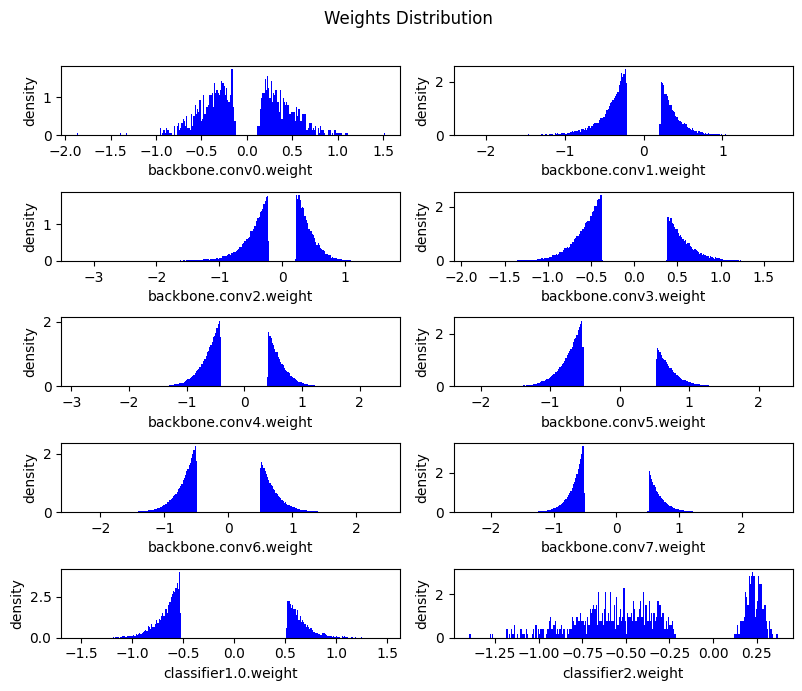

In [50]:
# Plot weights distribution
plot_weight_distribution(model, non_zeros = True)

We can see that, we pruned the weights which are near to zero from every layers without much accuracy drop. This happens because near zero weights are not so important. So pruning them doesn't cost much.

### **Each layer's params after pruning**
I considered only the nonzeros elements.

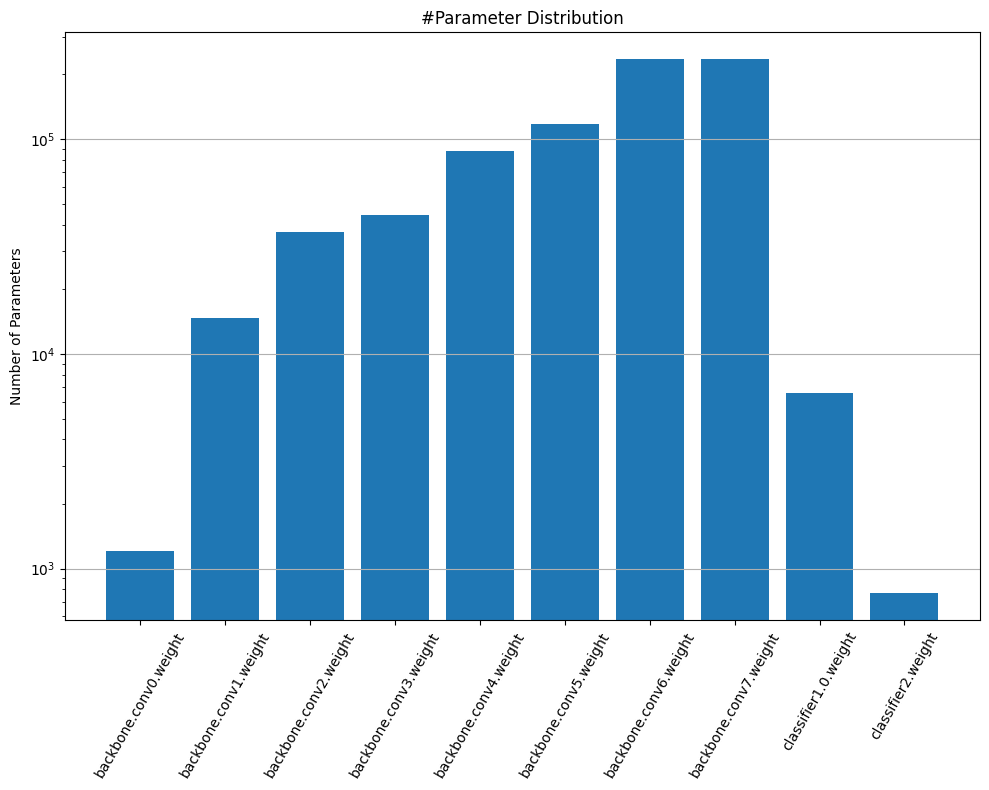

In [56]:
# Plot ea h layer's params number
plot_num_params(model, nonzeros = True)

### **Model Size and Accuracy after Pruning**
During calculation of model size, I count only the nonzeros weights.

It helps to compare the pruned model with the original model in terms of accuracy and size. And shows how pruning make the model efficient.

In [64]:
# Accuracy and Size of both original and pruned model
pruned_acc = evaluate(model, test_loader)
pruned_size = model_size(model, non_zeros=True)
print(f'Pruned model accuracy: {pruned_acc:.1f}% ({original_acc:.1f}%)')
print(f'Pruned model size is : {pruned_size:.2f} MiB ({original_size:.2f} MiB)')

Pruned model accuracy: 91.4% (92.2%)
Pruned model size is : 3.00 MiB (18.14 MiB)
